In [1]:
import pandas as pd
import numpy as np
import sqlite3
import dowhy
import causallearn
import matplotlib.pyplot as plt
import networkx as nx

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

In [2]:
pd.set_option("display.max_columns", 0)

In [3]:
CHEMBLDB_PATH = "/Users/patrickrowe/Documents/Code/data/chembl/chembl_35/chembl_35_sqlite/chembl_35.db"

SQL_QUERY = """SELECT * FROM ASSAYS WHERE ASSAY_TYPE IS 'P'"""
SQL_QUERY_WITH_IDS = """SELECT 
                        molregno, assays.assay_id, description, confidence_score, chembl_id, data_validity_comment, value, units, type
                        FROM assays
                        INNER JOIN activities AS act
                        ON assays.assay_id = act.assay_id 
                        WHERE ASSAY_TYPE is 'P'
                    """

In [4]:
con = sqlite3.connect(CHEMBLDB_PATH)
cur = con.cursor()

In [5]:
cur.execute(SQL_QUERY_WITH_IDS)

In [6]:
column_headers = [d[0] for d in cur.description]
print("molregno" in column_headers)
print(column_headers)
print(cur.fetchone())

True
['molregno', 'assay_id', 'description', 'confidence_score', 'chembl_id', 'data_validity_comment', 'value', 'units', 'type']
(146533, 4508, 'Partition coefficient was measured in octanol/pH7.4 phosphate buffer as -log (counts per min )', 0, 'CHEMBL618175', None, 0.5, 'c.p.m.', 'logP')


In [7]:
chembl_a_p_raw = pd.read_sql_query(SQL_QUERY_WITH_IDS, con=con)

In [8]:
chembl_a_p_raw

,molregno,assay_id,description,confidence_score,chembl_id,data_validity_comment,value,units,type
0,146533,4508,Partition coefficient was measured in octanol/...,0,CHEMBL618175,None,0.50,c.p.m.,logP
1,195927,4894,Partition coefficient (logP),0,CHEMBL858280,None,2.85,None,logP
2,195926,4894,Partition coefficient (logP),0,CHEMBL858280,None,3.73,None,logP
3,195915,4894,Partition coefficient (logP),0,CHEMBL858280,None,4.37,None,logP
4,195677,4894,Partition coefficient (logP),0,CHEMBL858280,None,3.97,None,logP
...,...,...,...,...,...,...,...,...,...
181530,2881545,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,3.60,None,LogD
181531,2881907,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,2.90,None,LogD
181532,2881578,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,3.00,None,LogD
181533,2881544,2382022,LogD measurement using 2.5 uL of 20 mM DMSO st...,0,CHEMBL5442686,None,-0.50,None,LogD


In [416]:
chembl_a_p = chembl_a_p_raw[chembl_a_p_raw.groupby("description").transform("size") > 250]


In [430]:
print(f"Began with {len(chembl_a_p_raw)} rows, for {len(set(chembl_a_p_raw.description.to_list()))} assays and {len(set(chembl_a_p_raw.chembl_id.to_list()))} molecules.\n")
print(f"Filtered to {len(chembl_a_p)} rows, for {len(set(chembl_a_p.description.to_list()))} assays and {len(set(chembl_a_p.chembl_id.to_list()))} moleucles.\n")
print(f"{chembl_a_p["description"].value_counts()}")


Began with 181535 rows, for 17943 assays and 25734 molecules.

Filtered to 48709 rows, for 50 assays and 4596 moleucles.

description
Partition coefficient (logP)                                                                                                                                                           5843
ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured  by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5      4200
Dissociation constant, pKa of the compound                                                                                                                                             3396
Lipophilicity, log P of the compound                                                                                                                                                   2850
Lipophilicity, log D of the compound at pH 7.4                                                                    

In [470]:
pivoted = pd.pivot_table(chembl_a_p, values=['value'], index='molregno', columns=['description']).sort_index().pipe(
    lambda s: s.set_axis(s.columns.map("_".join), axis=1)
)

In [471]:
pivoted

,value_ASTRAZENECA: Most basic pKa value (pKa B1) determined by absorption and potentiometric titration using standard methodology from Sirius Analytical. Experimental range Bases: >= 2.,"value_ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5","value_ASTRAZENECA: Solubility in pH7.4 buffer using solid starting material using the method described in J. Assoc. Lab. Autom. 2011, 16, 276-284. Experimental range 0.10 to 1500 uM",value_Aqueous solubility,value_Aqueous solubility at pH 7.4,value_Aqueous solubility of compound,value_Aqueous solubility of the compound,value_Aqueous solubility of the compound at pH 7.4,value_Calculated partition coefficient (clogP),value_Dissociation constant (pKa),"value_Dissociation constant, pKa of the compound","value_Distribution coefficient, log D of the compound","value_Distribution coefficient, log D of the compound at pH 7.4",value_Ionization constant (pKa),value_Kinetic aqueous solubility of the compound,value_Kinetic solubility of compound,value_Kinetic solubility of the compound,value_Kinetic solubility of the compound at pH 7.4,"value_Lipophilicity, log D at pH 7.4","value_Lipophilicity, log D of compound at pH 7.4","value_Lipophilicity, log D of the compound","value_Lipophilicity, log D of the compound at pH 7.4","value_Lipophilicity, log D of the compound at pH 7.4 by HPLC analysis","value_Lipophilicity, log D of the compound at pH 7.4 by chromatographic method","value_Lipophilicity, log D of the compound at pH 7.4 by shake flask method","value_Lipophilicity, log P of the compound","value_Lipophilicity, logD of compound at pH 7.4","value_Lipophilicity, logD of the compound at pH 7.4","value_Lipophilicity, logP of the compound","value_Octanol-buffer partition coefficient, log P of the compound","value_Octanol-water partition coefficient, log P of the compound",value_Partition coefficient (logD6.5),value_Partition coefficient (logD7.4),value_Partition coefficient (logP),value_Partition coefficient (logP) (HPLC),"value_Partition coefficient, log P of the compound",value_Retention time of the compound,value_Retention time of the compound by HPLC analysis,value_SUPPLEMENTARY: Lipophilicity (log D) Determination by high-throughput shake-flask,value_SUPPLEMENTARY: Lyophilisation Solubility Assay (LYSA),value_SUPPLEMENTARY: PAMPA permeability assay,value_Solubility at pH 7.4,value_Solubility in water,value_Solubility of compound in water,value_Solubility of the compound,value_Solubility of the compound at pH 6.8,value_Solubility of the compound at pH 7,value_Solubility of the compound at pH 7.4,value_Solubility of the compound in DMSO,value_Solubility of the compound in water
molregno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
97,NaN,1.90,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.75,NaN,NaN,6.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.74,NaN,NaN,8.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.39,NaN,NaN,NaN,NaN,NaN,-0.34,0.4,NaN,NaN,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,8.1,-0.45,NaN,NaN,NaN,NaN,NaN,NaN,5.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,NaN,-0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN,0.0097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# Normalise data, set "nearly 0" to zero for convenience
pivoted = (pivoted - pivoted.mean())/pivoted.std()
pivoted[np.abs(pivoted) < 1e-9] = 0

In [452]:
name_remapping = {
    # pKa assays
    'value_ASTRAZENECA: Most basic pKa value (pKa B1) determined by absorption and potentiometric titration using standard methodology from Sirius Analytical. Experimental range Bases: >= 2.': 'pKa',
    'value_Dissociation constant (pKa)': 'pKa',
    'value_Dissociation constant, pKa of the compound': 'pKa',
    'value_Ionization constant (pKa)': 'pKa',
    
    # LogD (distribution coefficient at pH 7.4)
    'value_ASTRAZENECA: Octan-1-ol/water (pH7.4) distribution coefficent measured  by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355. Experimental range -1.5 to 4.5': 'LogD',
    'value_Distribution coefficient, log D of the compound': 'LogD',
    'value_Distribution coefficient, log D of the compound at pH 7.4': 'LogD',
    'value_Lipophilicity, log D at pH 7.4': 'LogD',
    'value_Lipophilicity, log D of compound at pH 7.4': 'LogD',
    'value_Lipophilicity, log D of the compound': 'LogD',
    'value_Lipophilicity, log D of the compound at pH 7.4': 'LogD',
    'value_Lipophilicity, log D of the compound at pH 7.4 by HPLC analysis': 'LogD',
    'value_Lipophilicity, log D of the compound at pH 7.4 by chromatographic method': 'LogD',
    'value_Lipophilicity, log D of the compound at pH 7.4 by shake flask method': 'LogD',
    'value_Lipophilicity, logD of compound at pH 7.4': 'LogD',
    'value_Lipophilicity, logD of the compound at pH 7.4': 'LogD',
    'value_Partition coefficient (logD7.4)': 'LogD',
    'value_SUPPLEMENTARY: Lipophilicity (log D) Determination by high-throughput shake-flask': 'LogD',
    
    # LogP (partition coefficient)
    'value_Calculated partition coefficient (clogP)': 'cLogP',
    'value_Lipophilicity, log P of the compound': 'LogP',
    'value_Lipophilicity, logP of the compound': 'LogP',
    'value_Octanol-buffer partition coefficient, log P of the compound': 'LogP',
    'value_Octanol-water partition coefficient, log P of the compound': 'LogP',
    'value_Partition coefficient (logP)': 'LogP',
    'value_Partition coefficient (logP) (HPLC)': 'LogP',
    'value_Partition coefficient, log P of the compound': 'LogP',
    
    # Aqueous solubility (pH 7.4)
    'value_ASTRAZENECA: Solubility in pH7.4 buffer using solid starting material using the method described in J. Assoc. Lab. Autom. 2011, 16, 276-284. Experimental range 0.10 to 1500 uM': 'Aqueous Solubility',
    'value_Aqueous solubility': 'Aqueous Solubility',
    'value_Aqueous solubility at pH 7.4': 'Aqueous Solubility',
    'value_Aqueous solubility of compound': 'Aqueous Solubility',
    'value_Aqueous solubility of the compound': 'Aqueous Solubility',
    'value_Aqueous solubility of the compound at pH 7.4': 'Aqueous Solubility',
    'value_Solubility at pH 7.4': 'Aqueous Solubility',
    'value_Solubility in water': 'Aqueous Solubility',
    'value_Solubility of compound in water': 'Aqueous Solubility',
    'value_Solubility of the compound': 'Aqueous Solubility',
    'value_Solubility of the compound in water': 'Aqueous Solubility',
    'value_Solubility of the compound at pH 7.4': 'Aqueous Solubility',
    
    # Kinetic solubility
    'value_Kinetic aqueous solubility of the compound': 'Kinetic Solubility',
    'value_Kinetic solubility of compound': 'Kinetic Solubility',
    'value_Kinetic solubility of the compound': 'Kinetic Solubility',
    'value_Kinetic solubility of the compound at pH 7.4': 'Kinetic Solubility',
    
    # HPLC retention time
    'value_Retention time of the compound': 'Retention Time',
    'value_Retention time of the compound by HPLC analysis': 'Retention Time',
    
    # Special pH conditions
    'value_Partition coefficient (logD6.5)': 'LogD_pH6.5',
    'value_Solubility of the compound at pH 6.8': 'Solubility_pH6.8',
    'value_Solubility of the compound at pH 7': 'Solubility_pH7',
    
    # DMSO solubility
    'value_Solubility of the compound in DMSO': 'DMSO Solubility',
    
    # Specialized assays
    'value_SUPPLEMENTARY: Lyophilisation Solubility Assay (LYSA)': 'LYSA',
    'value_SUPPLEMENTARY: PAMPA permeability assay': 'PAMPA Permeability'
}

# Remap columns which _probably_ refer to identical assays, and take the mean where multiple values are found
pivoted = pivoted.rename(columns=name_remapping)
pivoted = pivoted.groupby(level=0, axis=1).mean()

/var/folders/ql/140bddls19x4s8xyk9nrwyd00000gn/T/ipykernel_24713/3817087152.py:73: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pivoted = pivoted.groupby(level=0, axis=1).mean()


In [461]:
# Only select molecules with >2 measurements each
pivoted = pivoted[pivoted.notna().sum(axis=1).gt(2)]
# Fill nans with mean
pivoted = pivoted.fillna(value=pivoted.mean(axis=1))

In [462]:
# Some sets of assays (e.g. HPLC) are orthogonal to others, so drop these columns
# pivoted = pivoted.dropna(axis=1)

In [463]:
pivoted

,Aqueous Solubility,Kinetic Solubility,LYSA,LogD,LogD_pH6.5,LogP,PAMPA Permeability,Retention Time,Solubility_pH6.8,Solubility_pH7,cLogP,pKa
molregno,,,,,,,,,,,,
97,-0.527823,0.201232,0.056879,-0.238369,-0.097683,-0.080691,0.038295,-0.495319,3.258961,7.145649,-0.111376,-0.402772
115,0.133344,0.201232,0.056879,-0.775956,-0.766176,-0.533814,0.038295,-0.495319,3.258961,7.145649,-0.111376,-0.023461
146,0.133344,0.201232,0.056879,-2.192166,-0.305195,-0.080691,0.038295,-0.495319,3.258961,7.145649,0.079257,0.210185
173,-0.460485,0.201232,0.056879,-0.905058,0.498148,0.161897,0.038295,-0.495319,3.258961,13.832169,-0.111376,-1.204150
241,0.201625,-0.599821,0.056879,-1.580611,-0.305195,-0.593747,0.038295,-0.495319,3.258961,7.145649,-0.218780,0.257907
...,...,...,...,...,...,...,...,...,...,...,...,...
2763014,0.133344,0.201232,0.056879,0.002254,-0.305195,0.068888,0.038295,-0.495319,3.258961,7.145649,-0.111376,0.339712
2777134,0.133344,-0.585330,0.056879,-0.593287,-0.305195,-0.080691,0.038295,-0.495319,3.258961,7.145649,-0.111376,0.367761
2832775,15.314202,0.201232,0.056879,-1.299068,-0.305195,-0.080691,0.038295,-0.495319,3.258961,7.145649,-0.111376,-0.136493


In [464]:
print(pivoted.columns.to_list())

['Aqueous Solubility', 'Kinetic Solubility', 'LYSA', 'LogD', 'LogD_pH6.5', 'LogP', 'PAMPA Permeability', 'Retention Time', 'Solubility_pH6.8', 'Solubility_pH7', 'cLogP', 'pKa']


In [465]:
cg = pc(pivoted.to_numpy(), node_names=pivoted.columns.to_list())

  0%|          | 0/12 [00:00<?, ?it/s]

In [466]:
cg.to_nx_graph()


In [467]:
chembl_causal_graph = cg.nx_graph

Green: undirected; Blue: directed; Red: bi-directed



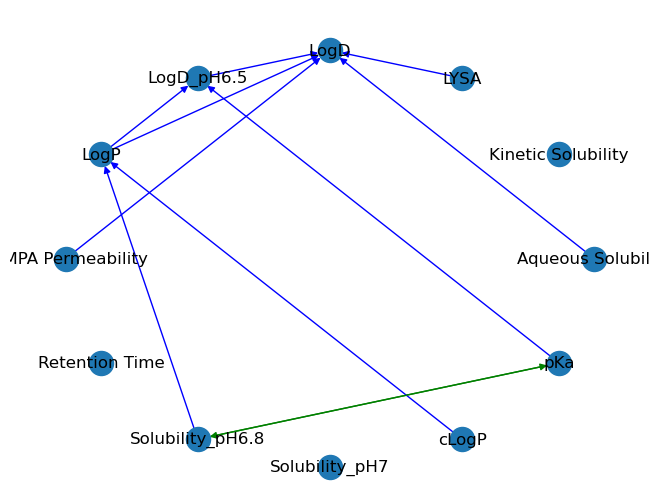

In [468]:
cg.draw_nx_graph()